In [3]:
from latentmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc 
from tqdm.notebook import tqdm
import os

loop through each folder in PBMC_CITE_seq embeddings
estimate MI
record in df

In [2]:
# base directory for embeddings
embeddings_dir = '../embeddings/PBMC_CITEseq/'
results = []

# loop through quality and replicate subdirectories
for quality_dir in os.listdir(embeddings_dir):
    quality_path = os.path.join(embeddings_dir, quality_dir)
    if not os.path.isdir(quality_path):
        continue

    # find held-out cells
    held_out_path = os.path.join(quality_path, 'held_out_cells.h5ad')
    held_out = sc.read_h5ad(held_out_path)

    UMI_per_cell = held_out.raw.X.sum()/len(held_out)

    protein_counts = held_out.obsm['protein_counts']

    celltype_coarse = pd.get_dummies(held_out.obs['celltype.l1']).to_numpy()
    celltype_fine = pd.get_dummies(held_out.obs['celltype.l3']).to_numpy()

    # loop through embedding files
    for file in tqdm(os.listdir(quality_path), desc=f"Processing {quality_dir}"):
        if not file.endswith('.npy'):
            continue

        # extract method and fraction from filename
        method, frac = file.split('_')
        frac = frac[4:-4]

        # load embeddings
        embedding_path = os.path.join(quality_path, file)
        embeddings = np.load(embedding_path)

        # estimate MI
        pmis, _, _ = lmi.estimate(embeddings, protein_counts, quiet=True, batch_size=2048)
        protein_mi = np.nanmean(pmis)

        # estimate MI for cell type
        pmis, _, _ = lmi.estimate(embeddings, celltype_coarse, quiet=True, batch_size=2048)
        ct_coarse_mi = np.nanmean(pmis)

        pmis, _, _ = lmi.estimate(embeddings, celltype_fine, quiet=True, batch_size=2048)
        ct_fine_mi = np.nanmean(pmis)

        # save result
        results.append({
            'Quality': quality_dir.split('_')[0],
            'UMI per cell' : UMI_per_cell,
            'Replicate': quality_dir.split('_')[1],
            'Fraction': float(frac),

            # watch out ! this needs to be tweaked if we change hold out size
            'Cell number' : int(float(frac)*3*len(held_out)),
            'Method': method,
            'Protein MI': protein_mi,
            'Cell type coarse MI': ct_coarse_mi,
            'Cell type fine MI': ct_fine_mi
        })

Processing Q0.001_rep0:   0%|          | 0/32 [00:00<?, ?it/s]

epoch 298 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.005_rep0:   0%|          | 0/32 [00:00<?, ?it/s]

epoch 186 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.022_rep0:   0%|          | 0/32 [00:00<?, ?it/s]

epoch 277 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.100_rep0:   0%|          | 0/32 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.464_rep0:   0%|          | 0/32 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

In [3]:
df = pd.DataFrame(results)
df

,Quality,UMI per cell,Replicate,Fraction,Cell number,Method,Protein MI,Cell type coarse MI,Cell type fine MI
0,Q0.001,8.166369,rep0,0.001,114,VAE,0.344281,0.344395,0.407547
1,Q0.001,8.166369,rep0,0.001,114,PCA,0.367951,0.346469,0.381196
2,Q0.001,8.166369,rep0,0.001,114,RandomProjection,0.393428,0.348323,0.395545
3,Q0.001,8.166369,rep0,0.001,114,nanoTxformer,0.370142,0.416490,0.422667
4,Q0.001,8.166369,rep0,0.006,684,VAE,0.373950,0.340842,0.403558
...,...,...,...,...,...,...,...,...,...
85,Q0.464,3784.577635,rep0,0.178,20304,RandomProjection,2.445523,1.794527,2.299772
86,Q0.464,3784.577635,rep0,1.000,114072,VAE,4.249317,2.278473,3.477583
87,Q0.464,3784.577635,rep0,1.000,114072,PCA,4.050932,2.132228,3.197877
88,Q0.464,3784.577635,rep0,1.000,114072,RandomProjection,2.602537,1.853744,2.462524


<Axes: xlabel='Fraction', ylabel='Protein MI'>

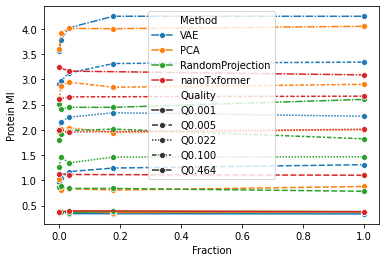

In [4]:
sns.lineplot(df, x='Fraction', y='Protein MI', style='Quality', 
             hue='Method', marker='o')

<Axes: xlabel='Fraction', ylabel='Cell type coarse MI'>

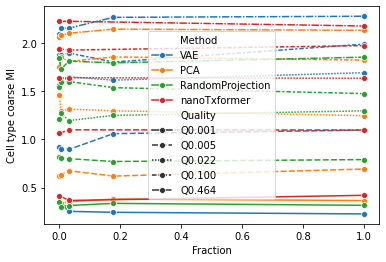

In [5]:
sns.lineplot(df, x='Fraction', y='Cell type coarse MI', style='Quality', 
             hue='Method', marker='o')

<Axes: xlabel='Fraction', ylabel='Cell type fine MI'>

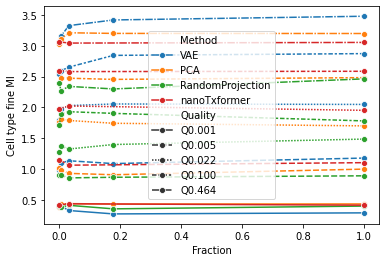

In [6]:
sns.lineplot(df, x='Fraction', y='Cell type fine MI', style='Quality', 
             hue='Method', marker='o')

In [7]:
df.to_csv('../results/PBMC_CITEseq_scaling.csv')

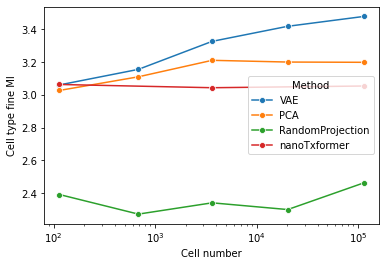

In [16]:
g = sns.lineplot(df[df['Quality']=='Q0.464'], x='Cell number', y='Cell type fine MI', 
             hue='Method', marker='o')
g.set_xscale('log')

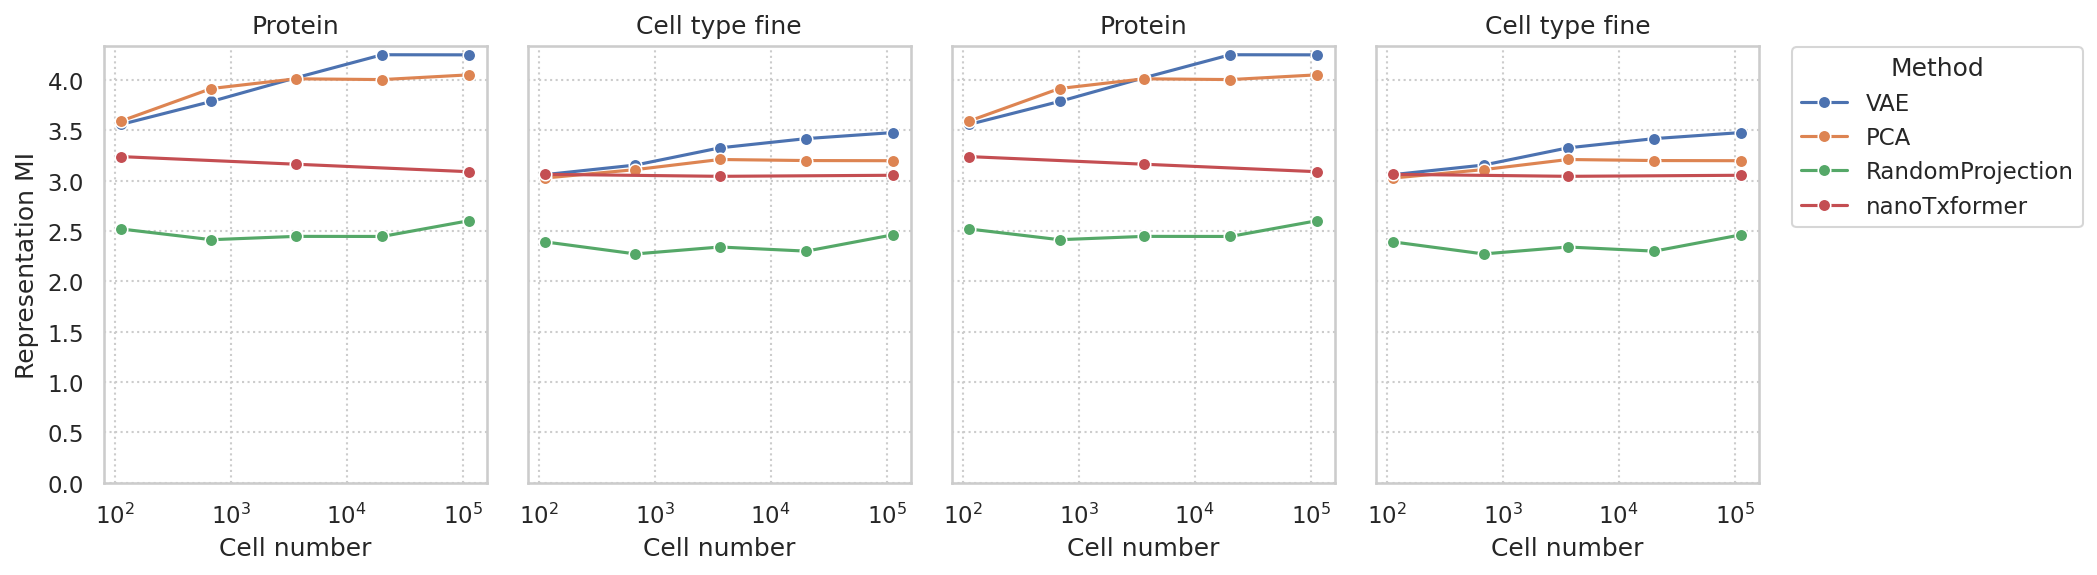

In [25]:
df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv')

# set seaborn style
sns.set(style="whitegrid", rc={"grid.linestyle": ":"})  # dotted grid lines!

# create subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4), dpi=150, sharey=True)

# plot specific sns.lineplot on each subplot
to_plot = ['Protein MI', 'Cell type fine MI'] * 2
for i in range(4):
    ax = axes[i]

    g = sns.lineplot(
        data=df[df['Quality'] == 'Q0.464'],
        x='Cell number',
        y=to_plot[i],
        hue='Method',
        marker='o',
        ax=ax
    )
    g.set_xscale('log')  # log scale for x-axis
    g.set_ylim(0)
    g.set_title(to_plot[i][:-3])
    ax.get_legend().remove()  # remove duplicate legends

# add a single legend on the right side
handles, labels = axes[0].get_legend_handles_labels()  # grab from first plot
fig.legend(handles, labels, loc='center right', title="Method", bbox_to_anchor=(1.17, 0.75))
axes[0].set_ylabel('Representation MI')

plt.subplots_adjust(right=0.85)  # make space for the legend
plt.tight_layout()
plt.show()
